## Homeless Encampments in LA

##### Spring 2025
##### Amanda Alonzo
##### I513 Usable AI
##### Indiana University, Bloomington
 


## Machine Learning Predictions

### In this notebook, we will simplify the columns for machine learning tasks by:
- using OneHotEncoding (OHE) for location neighborhood area
- scaling

### We will make predictions for:
- ticket close time and
- number of encampments
##### <i> Prerequisite: 6_zip_visualization.ipynb </i>

TODO: Remove outliers

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler

In [2]:
raw_data_path = "../Dataraw/"
annual_data_path = "../Datafiles/"
generated_data_path = "../Datagen/"

In [3]:
#laod  our data frame from past steps 
df_source = pd.read_csv(generated_data_path+'homeless_camp_closed_2023_parks_zip_ftr_eng_1.csv', low_memory=False)
df_source.head(1)

,SRNumber,CreatedDate,UpdatedDate,ActionTaken,Owner,RequestType,Status,RequestSource,CreatedByUserOrganization,MobileOS,...,Shape__Area_y,Shape__Length_y,close_time_bins,is_county_ind,park_distance_bins,closed_days_scaled,park_distance_scaled,ZIP Code,JENI Need Tier,JENI_TIER
0,1-3202726931,01/01/2023 08:26:17 AM,01/31/2023 01:44:42 PM,SR Created,LASAN,Homeless Encampment,Closed,Self Service,Self Service_SAN,NaN,...,476404.567383,2824.807047,1.0,0,2,0.039295,0.054729,90063.0,High,4.0


## Preparare Data with Transformations for ML Tasks

In [4]:
df_source.shape

(63104, 154)

In [5]:
#Clean up our data frame - simplify columns
df = df_source[['RequestSource','ZipCodeFmt','Anonymous','AssignTo','park_distance_bins','close_time_days_x','is_county_ind','NDS_AN_TYP','COGP_TYP','ACCESS_TYP','JENI_TIER']].copy()


In [6]:
df.columns = df.columns.str.lower()
df.describe()

,zipcodefmt,park_distance_bins,close_time_days_x,is_county_ind,jeni_tier
count,63090.000000,63104.000000,63079.000000,63104.000000,63076.000000
mean,90465.801886,0.967989,84.476212,0.980619,3.844679
std,634.715178,0.955762,95.161704,0.137860,1.164308
min,90001.000000,0.000000,0.000000,0.000000,1.000000
25%,90025.000000,0.000000,7.000000,1.000000,3.000000
50%,90048.000000,1.000000,54.000000,1.000000,4.000000
75%,91311.000000,2.000000,125.000000,1.000000,5.000000
max,91607.000000,4.000000,738.000000,1.000000,5.000000


In [7]:
df.columns

Index(['requestsource', 'zipcodefmt', 'anonymous', 'assignto',
       'park_distance_bins', 'close_time_days_x', 'is_county_ind',
       'nds_an_typ', 'cogp_typ', 'access_typ', 'jeni_tier'],
      dtype='object')

In [8]:
df.assignto.value_counts()

assignto
NC     22585
EV     12061
WLA    10768
SLA     9317
WV      6791
HB      1190
LSD      391
Name: count, dtype: int64

In [9]:
df.groupby('assignto').agg({'zipcodefmt': ['min', 'max']}   )

zipcodefmt         
                min      max
assignto                    
EV          90068.0  91607.0
HB          90044.0  90744.0
LSD         90007.0  90021.0
NC          90004.0  90732.0
SLA         90001.0  90062.0
WLA         90008.0  90404.0
WV          90049.0  91436.0

In [10]:
df.groupby('zipcodefmt').assignto.value_counts()

zipcodefmt  assignto
90001.0     SLA          206
90002.0     SLA          286
90003.0     SLA         1416
90004.0     NC          1216
90005.0     NC          1434
                        ... 
91602.0     EV           947
91604.0     EV           365
91605.0     EV           903
91606.0     EV          1568
91607.0     EV           219
Name: count, Length: 147, dtype: int64

In [11]:
df.shape

(63104, 11)

In [12]:
df = df.dropna()

In [13]:
df.shape

(63050, 11)

In [14]:
df = df.rename(columns={'close_time_days_x': 'close_time_days' })
df.head(1)

,requestsource,zipcodefmt,anonymous,assignto,park_distance_bins,close_time_days,is_county_ind,nds_an_typ,cogp_typ,access_typ,jeni_tier
0,Self Service,90063.0,Y,NC,2,29.0,0,Park 5 to 100 Acres,Neighborhood,Open Access,4.0


In [15]:
#ohe the zip code and neighborhood
# add this later depending on svc performance: 'zipcodefmt',

# too many columns making SVC slow
df = pd.get_dummies(df, columns=['assignto'], dtype=int)
#df = pd.get_dummies(df, columns=['zipcodefmt'], dtype=int)


In [16]:
df.head(2)
#assignto abbreviations for values


,requestsource,zipcodefmt,anonymous,park_distance_bins,close_time_days,is_county_ind,nds_an_typ,cogp_typ,access_typ,jeni_tier,assignto_EV,assignto_HB,assignto_LSD,assignto_NC,assignto_SLA,assignto_WLA,assignto_WV
0,Self Service,90063.0,Y,2,29.0,0,Park 5 to 100 Acres,Neighborhood,Open Access,4.0,0,0,0,1,0,0,0
1,Self Service,90063.0,Y,2,29.0,0,Park 5 to 100 Acres,Neighborhood,Open Access,4.0,0,0,0,1,0,0,0


In [310]:
df.describe()

,zipcodefmt,park_distance_bins,close_time_days,is_county_ind,assignto_EV,assignto_HB,assignto_LSD,assignto_NC,assignto_SLA,assignto_WLA,assignto_WV
count,63064.000000,63064.000000,63064.000000,63064.000000,63064.000000,63064.000000,63064.000000,63064.000000,63064.000000,63064.00000,63064.000000
mean,90465.838545,0.967414,84.468540,0.980623,0.191218,0.018854,0.006200,0.358017,0.147501,0.17062,0.107589
std,634.749417,0.954842,95.155571,0.137848,0.393264,0.136010,0.078497,0.479421,0.354607,0.37618,0.309863
min,90001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,90025.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,90048.000000,1.000000,54.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,91311.000000,2.000000,125.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000
max,91607.000000,4.000000,738.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [17]:
numeric_variables = df.select_dtypes(include=np.number)

## Predict Service Ticket Close Time
### Prepare X and Y

In [32]:
x = df[list(numeric_variables.columns)]

In [33]:
x = x.drop(['is_county_ind','close_time_days','zipcodefmt'], axis =1)
x.head(1)

,park_distance_bins,jeni_tier,assignto_EV,assignto_HB,assignto_LSD,assignto_NC,assignto_SLA,assignto_WLA,assignto_WV
0,2,4.0,0,0,0,1,0,0,0


In [34]:
y = df['close_time_days']

In [35]:
sc= StandardScaler()
sc.fit(x)
x_scaled = sc.transform(x)    


In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(x_scaled, y, test_size=.2) 


### Linear Regression

In [37]:

lm = LinearRegression()
lm.fit(x, y)

print(lm)

LinearRegression()


In [38]:
lm.coef_


array([  0.43154082,   1.80237767,  -9.00589772, -32.65609975,
        24.93270431,  -7.15897478,   6.46232272,   0.1521366 ,
        17.27380862])

In [39]:
lm.intercept_


np.float64(79.04454928366383)

In [40]:
linear = LinearRegression()

# train data
linear.fit(X_train, Y_train)

LinearRegression()

In [41]:
Y_predicted = linear.predict(X_test)



In [42]:
# correlation
corr_linear = pd.Series(Y_predicted).corr(pd.Series(Y_test), method='spearman')

# r2_score
rsquared_linear = r2_score(Y_test, Y_predicted)

In [43]:
rsquared_linear, corr_linear

(0.01022266290716678, np.float64(-0.0049243069500676554))

In [44]:
# Check the coefficients of the models of 10 features by checking the linear coefficients
print(linear.coef_)

[ 0.52224863  1.82464261 -2.87030641 -4.14405212  2.04991877 -2.8192531
  2.74650351  0.26778346  5.83552449]


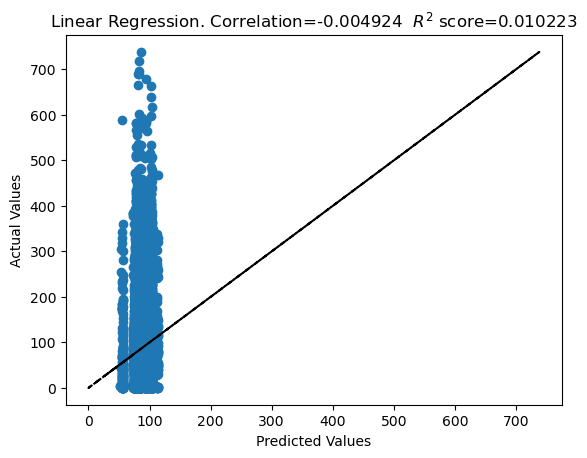

In [45]:
plt.scatter(Y_predicted, Y_test)

plt.title("Linear Regression. Correlation=%f  $R^2$ score=%f" % (corr_linear, rsquared_linear))

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

# plot a diagonal line
plt.plot(Y_test, Y_test, 'k--') # 'k--' = black dashed lines
plt.show()

# Graphical representation

### SVR


In [46]:
X_train.shape

(50440, 9)

In [47]:
Y_train.shape

(50440,)

In [48]:
# poly takes a long time
# other types : ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
# adding , probability=False to try to improve performance
svr = SVR(kernel='rbf', C=1.0,   cache_size=7000, )  
svr.fit(X_train , Y_train )
 

SVR(cache_size=7000)

In [49]:

y_pred = svr.predict(X_test ) 

 

In [50]:
y_pred.size

12610

In [52]:
# correlation
corr_svr = pd.Series(y_pred).corr(pd.Series(Y_test), method='spearman')

# r2_score
rsquared_svr = r2_score(Y_test, y_pred)

In [53]:
rsquared_svr, corr_svr

(-0.08299688601141808, np.float64(0.03092360302370222))

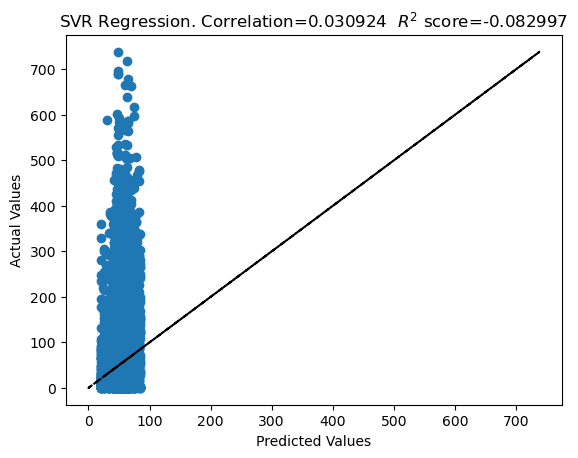

In [55]:
plt.scatter(y_pred, Y_test)

plt.title("SVR Regression. Correlation=%f  $R^2$ score=%f" % (corr_svr, rsquared_svr))

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

# plot a diagonal line
plt.plot(Y_test, Y_test, 'k--') # 'k--' = black dashed lines
plt.show()

# Graphical representation

## Predict Volume of Encampment Tickets 


### Prepare data


In [ ]:
numeric_variables.columns.size

In [ ]:
num_cols = list(numeric_variables) 
#zip_cols = num_cols[3:]
#zip_cols[0]
num_cols[0:5]

In [ ]:

new_df = df.copy()
counts_df = new_df.groupby(['jini_tier','park_distance_bins','assignto_EV','assignto_HB','assignto_LSD','assignto_NC','assignto_SLA','assignto_WLA','assignto_WV']).size().reset_index(name="cnt")

#counts_df = new_df.groupby(num_cols).size().reset_index(name='count')


In [ ]:
counts_df.shape

In [ ]:
counts_df.dropna()
counts_df.size

In [ ]:
counts_df.shape

In [ ]:
counts_df.head(1)

In [330]:
counts_df[counts_df['cnt'].isna()==True].size

0

In [334]:
#counts_df = counts_df.dropna()
counts_df.shape

(34, 9)

In [335]:

x  = counts_df.copy() 
x.shape

(34, 9)

In [338]:

x.drop(['cnt'] , axis=1)
x.dropna()


,park_distance_bins,assignto_EV,assignto_HB,assignto_LSD,assignto_NC,assignto_SLA,assignto_WLA,assignto_WV,cnt
0,0,0,0,0,0,0,0,1,1282
1,0,0,0,0,0,0,1,0,3213
2,0,0,0,0,0,1,0,0,3970
3,0,0,0,0,1,0,0,0,11306
4,0,0,0,1,0,0,0,0,120
5,0,0,1,0,0,0,0,0,545
6,0,1,0,0,0,0,0,0,3671
7,1,0,0,0,0,0,0,1,1982
8,1,0,0,0,0,0,1,0,3546
9,1,0,0,0,0,1,0,0,4032


In [357]:
y = counts_df['cnt']
#y = y.copy()
#y.min(), y.max(), y['volume_cnt'].size, y.size
y.size

34

In [358]:
y.head(1)

0    1282
Name: cnt, dtype: int64

In [359]:
#x.shape, y.shape, counts_df.shape, df.shape,  y['cnt'].shape

In [345]:
y['cnt']

0      1282
1      3213
2      3970
3     11306
4       120
5       545
6      3671
7      1982
8      3546
9      4032
10     7397
11      143
12      402
13     4146
14     2219
15     2376
16     1266
17     3593
18      126
19      199
20     3746
21     1034
22     1037
23       33
24      269
25        2
26       19
27      431
28      268
29      588
30        1
31       13
32       24
33       65
Name: cnt, dtype: int64

In [376]:

 X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=.2) 


In [385]:
len(X_train.index), len(X_test.index), len(Y_train.index), len(Y_test.index)

(27, 7, 27, 7)

## Linear Regression

In [65]:
linear = LinearRegression()

# train data
linear.fit(X_train, Y_train)

LinearRegression()

In [66]:
Y_predicted = linear.predict(X_test)


In [67]:
# correlation method{‘pearson’, ‘kendall’, ‘spearman’} 
# as per professor, spearman because data is skewed 
corr_linear = pd.Series(Y_predicted).corr(pd.Series(Y_test), method='spearman')

# r2_score
rsquared_linear = r2_score(Y_test, Y_predicted)

In [ ]:
rsquared_linear, corr_linear

In [68]:
# Check the coefficients of the models of 10 features by checking the linear coefficients
print(linear.coef_)

[-3.12638804e-13 -2.66085106e+02  8.62914894e+02  1.59161573e-12
  8.80914894e+02  3.99914894e+02  3.00914894e+02 -3.60085106e+02
 -3.20851064e+01  5.28914894e+02  1.70530257e-13 -1.83085106e+02
  5.36914894e+02  1.92914894e+02 -4.20851064e+01 -1.17085106e+02
  5.27914894e+02  3.32914894e+02  2.29914894e+02 -2.70851064e+01
  0.00000000e+00  3.66914894e+02  1.98951966e-13 -1.13686838e-13
  2.50891489e+03  3.76914894e+02  4.49148936e+01 -1.98085106e+02
 -1.87085106e+02  6.01914894e+02  5.11590770e-13 -1.34085106e+02
  5.71914894e+02  3.13914894e+02 -2.41085106e+02 -2.27085106e+02
 -1.14085106e+02 -3.75085106e+02  2.56914894e+02  4.26325641e-14
  5.68434189e-13  2.27373675e-13  4.69914894e+02 -3.43085106e+02
  2.57791489e+03 -3.86085106e+02 -3.01085106e+02 -5.40012479e-13
 -1.90851064e+01  1.23791489e+03  3.19148936e+01  2.22914894e+02
 -2.18085106e+02  1.13686838e-13  1.13686838e-13 -5.51085106e+02
 -5.44085106e+02 -5.08085106e+02 -5.47085106e+02 -5.51085106e+02
  4.54747351e-13 -3.41060

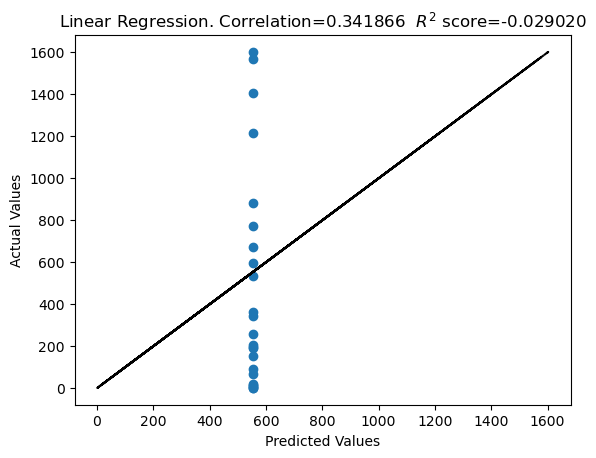

In [69]:
plt.scatter(Y_predicted, Y_test)

plt.title("Linear Regression. Correlation=%f  $R^2$ score=%f" % (corr_linear, rsquared_linear))

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

# plot a diagonal line
plt.plot(Y_test, Y_test, 'k--') # 'k--' = black dashed lines
plt.show()

# Graphical representati


## Predict Volume of Encampment Tickets

### 2. SVR


In [347]:
x.size

306

In [348]:
x.head(1)

,park_distance_bins,assignto_EV,assignto_HB,assignto_LSD,assignto_NC,assignto_SLA,assignto_WLA,assignto_WV,cnt
0,0,0,0,0,0,0,0,1,1282


In [362]:
y.head()

0     1282
1     3213
2     3970
3    11306
4      120
Name: cnt, dtype: int64

In [289]:
#counts_df.to_csv(generated_data_path +'wip3.csv' )

In [386]:

 X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=.2) 


In [387]:
len(X_train.index), len(X_test.index), len(Y_train.index), len(Y_test.index)

(27, 7, 27, 7)

In [364]:
# poly takes a long time
# other types : ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
svm= SVR(kernel='rbf', C=1.0 )  
svm.fit(X_train , Y_train )
y_pred = svm.predict(X_test ) 
 

In [389]:
len(y_pred)

7

In [365]:
# 3 columns SVC
# linear and rbf - 0.6319473034170441
# correlation
corr_svr = pd.Series(y_pred).corr( Y_test, method='spearman') 

# r2_score
rsquared_svr = r2_score(Y_test, y_pred)

In [366]:
Y_predicted.size

24

In [369]:
X_test.size

63

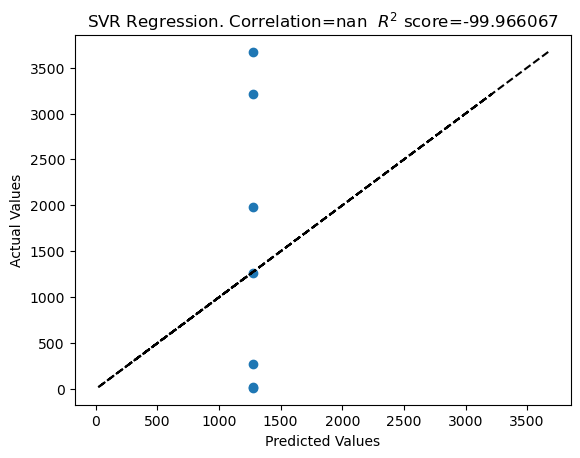

In [390]:
plt.scatter(y_pred, Y_test)

plt.title("SVR Regression. Correlation=%f  $R^2$ score=%f" % (corr_svr, rsquared_svr))

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")

# plot a diagonal line
plt.plot(Y_test, Y_test, 'k--') # 'k--' = black dashed lines
plt.show()

# Graphical representati

In [391]:
# Save to file for next step ML
df.to_csv(generated_data_path +'homeless_camp_closed_2023_parks_simplified_2.csv', index=False)

## Next: Try clustering - 6_ml_cluster.ipynb